<a href="https://colab.research.google.com/github/suhyeon0325/TIL/blob/main/laidd/ActivePathway_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ActivePathways 사용 메뉴얼:

https://cran.r-project.org/web/packages/ActivePathways/vignettes/ActivePathways-vignette.html 참조

## 환경설정
### 패지키 설치

In [ ]:
# Bioconductor에서 ActivePathways 설치
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install("ActivePathways")
install.packages("dplyr")  # 데이터 처리
install.packages("ggplot2")  # 플롯

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocVersion', 'ActivePathways'

Old packages: 'data.table', 'processx'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### 패키지 로딩

In [ ]:
library(ActivePathways)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### 데이터 불러오기

**췌장암 전사체 및 단백질 데이터**  
- 참고 논문: Hyeon, D.Y. et al., 2022, *Nature Cancer* ([링크](https://www.nature.com/articles/s43018-022-00479-7))  
- 총 111명의 환자 데이터 포함, 2개의 서브타입 (C1: 54명, C2: 57명)  

**입력 파일**  
- **P-value 행렬**: 두 개의 오믹스 데이터에서 중복되는 7,921개 유전자에 대해 서브타입 간 차등 발현 분석을 수행하여 얻은 P-value 값  
- **방향성(direction) 행렬**: 동일한 7,921개 유전자에 대해 서브타입 간 차등 발현 분석을 통해 계산된 발현 변화 방향 (Up/Down)  

**Reactome 유전자 세트 로드**  
ActivePathways 패키지에 포함된 GMT 파일을 활용해 Reactome 유전자 세트를 불러옴.  

**방향성(Directionality) 개념**  
방향성은 특정 유전자, 전사체, 단백질 등의 오믹스 데이터에서 발현 증가(Up) 또는 감소(Down)를 나타내며, 데이터 해석 시 중요한 역할을 함.

**데이터 로드**
- R 환경에서는 Google Drive 마운트가 어려울 수 있으므로, 데이터를 로컬에서 직접 업로드하는 방식 사용
- 제공된 파일 "PDAC_score.tsv", "PDAC_Differentail_exp_RNA_Protein.tsv"을 로컬로 다운로드


**Non-directionality Pathway 분석**
방향성을 고려하지 않는 분석
- 각 오믹스 데이터에서 변화 방향(Up/Down)을 무시하고 P-value만 활용
- 기존 ActivePathways 모델 사용 (https://www.nature.com/articles/s41467-019-13983-9)


### P-value 매트릭스 로드
업로드한 P-value 매트릭스 파일을 불러와 행렬로 변환

In [ ]:
# P-value 매트릭스 불러오기
scores <- read.table("/content/PDAC_score.tsv", header = TRUE, row.names = 'Gene')
scores <- as.matrix(scores)

In [ ]:
# NA 값이 있는 경우 P-value를 1로 치환하여 분석에 영향을 주지 않도록 처리
scores[is.na(scores)] <- 1

In [ ]:
head(scores)

,RNA_P,Protein_P
A1BG,0.938868440,0.81957849
A1CF,0.000000014,0.00000812
A2M,0.494333780,0.85116516
A2ML1,0.000620000,0.01554281
AAAS,0.127398071,0.51291151
AACS,0.000383000,0.17747420


In [ ]:
dim(scores)

[1] 7921    2

### Reactome GMT 파일 로드
**GMT 파일 개요**
- GMT 파일은 기능성 유전자 세트(pathways, biological process 등) 정보를 포함
- 한 줄에 하나의 gene set이 포함되며, 각 gene set은 다음과 같은 형식으로 구성됨
```
Gene set ID, 설명(description), 포함된 gene symbols  
```
- P-value 매트릭스의 유전자 ID와 GMT 파일의 유전자 ID가 일치해야 함
 - GMT 파일에서 gene symbol을 사용하면, P-value 매트릭스에서도 gene symbol을 사용
 - GMT 파일에서 entrez ID를 사용하면, P-value 매트릭스에서도 동일하게 entrez ID를 사용

- 출처: https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp

In [ ]:
# GMT 파일 불러오기
geneset <- read.GMT("/content/c2.cp.reactome.v2024.1.Hs.symbols.gmt")

In [ ]:
length(geneset)

[1] 1736

In [ ]:
names(geneset)

[1] "REACTOME_2_LTR_CIRCLE_FORMATION"                                                                                                              
   [2] "REACTOME_ABACAVIR_ADME"                                                                                                                       
   [3] "REACTOME_ABACAVIR_TRANSMEMBRANE_TRANSPORT"                                                                                                    
   [4] "REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT"                                                                                              
   [5] "REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS"                                                                                               
   [6] "REACTOME_ABC_TRANSPORTER_DISORDERS"                                                                                                           
   [7] "REACTOME_ABERRANT_REGULATION_OF_MITOTIC_EXIT_IN_CANCER_DUE_TO_RB1_DEFECTS"                                                                    
   [8] "REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS"                                                         
   [9] "REACTOME_ABORTIVE_ELONGATION_OF_HIV_1_TRANSCRIPT_IN_THE_ABSENCE_OF_TAT"                                                                       
  [10] "REACTOME_ACETYLCHOLINE_BINDING_AND_DOWNSTREAM_EVENTS"                                                                                         
  [11] "REACTOME_ACETYLCHOLINE_INHIBITS_CONTRACTION_OF_OUTER_HAIR_CELLS"                                                                              
  [12] "REACTOME_ACETYLCHOLINE_NEUROTRANSMITTER_RELEASE_CYCLE"                                                                                        
  [13] "REACTOME_ACETYLCHOLINE_REGULATES_INSULIN_SECRETION"                                                                                           
  [14] "REACTOME_ACROSOME_REACTION_AND_SPERM_OOCYTE_MEMBRANE_BINDING"                                                                                 
  [15] "REACTOME_ACTIVATED_NOTCH1_TRANSMITS_SIGNAL_TO_THE_NUCLEUS"                                                                                    
  [16] "REACTOME_ACTIVATED_NTRK2_SIGNALS_THROUGH_CDK5"                                                                                                
  [17] "REACTOME_ACTIVATED_NTRK2_SIGNALS_THROUGH_FRS2_AND_FRS3"                                                                                       
  [18] "REACTOME_ACTIVATED_NTRK2_SIGNALS_THROUGH_FYN"                                                                                                 
  [19] "REACTOME_ACTIVATED_NTRK2_SIGNALS_THROUGH_PI3K"                                                                                                
  [20] "REACTOME_ACTIVATED_NTRK2_SIGNALS_THROUGH_RAS"                                                                                                 
  [21] "REACTOME_ACTIVATED_NTRK3_SIGNALS_THROUGH_PI3K"                                                                                                
  [22] "REACTOME_ACTIVATED_NTRK3_SIGNALS_THROUGH_RAS"                                                                                                 
  [23] "REACTOME_ACTIVATED_PKN1_STIMULATES_TRANSCRIPTION_OF_AR_ANDROGEN_RECEPTOR_REGULATED_GENES_KLK2_AND_KLK3"                                       
  [24] "REACTOME_ACTIVATED_TAK1_MEDIATES_P38_MAPK_ACTIVATION"                                                                                         
  [25] "REACTOME_ACTIVATION_OF_AMPK_DOWNSTREAM_OF_NMDARS"                                                                                             
  [26] "REACTOME_ACTIVATION_OF_ANTERIOR_HOX_GENES_IN_HINDBRAIN_DEVELOPMENT_DURING_EARLY_EMBRYOGENESIS"                                                
  [27] "REACTOME_ACTIVATION_OF_ATR_IN_RESPONSE_TO_REPLICATION_STRESS"        

In [ ]:
# 특정 pathway 예시 출력
geneset$REACTOME_THE_ROLE_OF_NEF_IN_HIV_1_REPLICATION_AND_DISEASE_PATHOGENESIS

$id
[1] "REACTOME_THE_ROLE_OF_NEF_IN_HIV_1_REPLICATION_AND_DISEASE_PATHOGENESIS"

$name
[1] "https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/REACTOME_THE_ROLE_OF_NEF_IN_HIV_1_REPLICATION_AND_DISEASE_PATHOGENESIS"

$genes
 [1] "AP1B1"   "AP1G1"   "AP1M1"   "AP1M2"   "AP1S1"   "AP1S2"   "AP1S3"  
 [8] "AP2A1"   "AP2A2"   "AP2B1"   "AP2M1"   "AP2S1"   "ARF1"    "ATP6V1H"
[15] "B2M"     "CD247"   "CD28"    "CD4"     "CD8B"    "DOCK2"   "ELMO1"  
[22] "FYN"     "HCK"     "HLA-A"   "LCK"     "PACS1"   "PAK2"    "RAC1"

## ActivePathways 실행: P-value 병합 및 패스웨이 분석

ActivePathways 실행 전 준비 과정
ActivePathways를 실행하기 전에, **각 오믹스 데이터에서 유전자별 P-value를 추출하고, 이를 pathway 데이터(GMT 파일)와 매칭하는 과정**이 필요

In [ ]:
args(ActivePathways)  # 매개변수 확인
help(ActivePathways)  # 함수 설명문 출력

function (scores, gmt, background = makeBackground(gmt), geneset_filter = c(5, 
    1000), cutoff = 0.1, significant = 0.05, merge_method = c("Fisher", 
    "Fisher_directional", "Brown", "DPM", "Stouffer", "Stouffer_directional", 
    "Strube", "Strube_directional"), correction_method = c("holm", 
    "fdr", "hochberg", "hommel", "bonferroni", "BH", "BY", "none"), 
    cytoscape_file_tag = NA, color_palette = NULL, custom_colors = NULL, 
    color_integrated_only = "#FFFFF0", scores_direction = NULL, 
    constraints_vector = NULL) 
NULL

In [ ]:
# ActivePathways 실행: Brown’s method를 사용하여 P-value 병합 후 패스웨이 분석 수행
enriched_pathways_nondir <- ActivePathways(scores = scores, gmt = geneset, significant = 1, background = rownames(scores))

242 terms were removed from gmt because they did not make the geneset_filter



분석 결과 확인 및 필터링

In [ ]:
# 필터링된 패스웨이 개수 확인
dim(enriched_pathways_nondir)

[1] 1432    8

In [ ]:
# 가장 유의미한 패스웨이 상위 5개 조회 (adjusted P-value 기준 정렬)
head(enriched_pathways_nondir %>% arrange(adjusted_p_val), 5) %>% select(-c(term_name))

term_id,adjusted_p_val,term_size,overlap,evidence,Genes_RNA_P,Genes_Protein_P
<chr>,<dbl>,<int>,<list>,<list>,<list>,<list>
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,1.637238e-13,215,"MMP14 , SERPINH1, FN1 , CAPN5 , TNC , PLOD2 , ITGA5 , LOX , PLOD1 , CAPN8 , SPARC , PXDN , P4HA1 , LOXL2 , COL6A3 , CRTAP , COL5A1 , P3H1 , P3H3 , CAPN7 , BMP1 , COL5A2 , CTSL , ITGB1 , COL8A1 , COL12A1 , MFAP2 , COL5A3 , P4HA2 , COL3A1 , COLGALT1, HTRA1 , COL6A1 , COL11A1 , ADAM17 , CAPN9 , MMP2 , COL1A1 , TIMP2 , CAPN6 , CD44 , COL1A2 , VCAN , ITGAV , CTSK , THBS1 , SERPINE1, ACTN1 , CDH1 , LAMA1 , NID2 , DDR2 , EFEMP2 , ADAMTS2 , CTSB , CTSS , SDC1 , LOXL3 , FBN1 , COL28A1 , ITGA11 , EMILIN1 , SH3PXD2A, ADAMTS4 , LAMA4 , COL7A1 , LUM , PPIB , COL6A2 , ITGB3 , LTBP4 , ICAM1 , ITGA3 , KLKB1 , PRKCA , NID1 , ADAM15 , MMP11 , FBN2 , LAMC2 , PCOLCE , LAMB1 , MMP9 , MFAP5 , DMD , BSG , SDC2","RNA_P , Protein_P","FN1 , CAPN5 , LOX , MMP14 , SERPINH1, PLOD2 , ITGA5 , COL6A3 , CAPN8 , TNC , MFAP2 , COL8A1 , PXDN , COL5A2 , COL3A1 , COL5A1 , VCAN , COL6A1 , COL1A1 , CTSL , COL1A2 , ITGB1 , HTRA1 , PLOD1 , LOXL2 , COL12A1 , LAMA1 , SPARC , EFEMP2 , NID2 , P4HA1 , COL5A3 , FBN1 , MMP2 , CTSK , THBS1 , EMILIN1 , COL28A1 , CAPN9 , COL11A1 , ACTN1 , TIMP2 , LUM , LAMA4 , DDR2 , CAPN7 , CTSB , ITGA11 , NID1 , ADAM17 , FBN2 , PRKCA , PPIB , MFAP5 , SDC2 , PCOLCE , COL6A2 , SERPINE1, BMP1 , ADAMTS4 , KLKB1 , MMP9 , CAPN6 , ADAMTS2 , ADAM15 , LOXL3","MMP14 , CRTAP , SERPINH1, P3H1 , CAPN5 , TNC , CD44 , COLGALT1, P3H3 , P4HA2 , PLOD1 , FN1 , BMP1 , SPARC , P4HA1 , PLOD2 , ITGA5 , CTSS , CAPN7 , BSG , CDH1"
REACTOME_COLLAGEN_FORMATION,8.004797e-12,64,"SERPINH1, PLOD2 , LOX , PLOD1 , PXDN , P4HA1 , LOXL2 , COL6A3 , CRTAP , COL5A1 , P3H1 , P3H3 , BMP1 , COL5A2 , CTSL , COL8A1 , COL12A1 , COL5A3 , P4HA2 , COL3A1 , COLGALT1, COL6A1 , COL11A1 , COL1A1 , COL1A2","RNA_P , Protein_P","LOX , SERPINH1, PLOD2 , COL6A3 , COL8A1 , PXDN , COL5A2 , COL3A1 , COL5A1 , COL6A1 , COL1A1 , CTSL , COL1A2 , PLOD1 , LOXL2 , COL12A1 , P4HA1 , COL5A3 , COL28A1 , COL11A1 , CTSB , PPIB , PCOLCE , COL6A2 , BMP1 , MMP9 , ADAMTS2 , LOXL3 , COL10A1 , LOXL1 , COL8A2 , P3H3 , COL4A1 , LAMC2 , P4HA2 , COL15A1 , COL6A6 , CRTAP , COL4A2 , COL18A1 , P3H1 , P4HB , COL4A4 , COLGALT1","CRTAP , SERPINH1, P3H1 , COLGALT1, P3H3 , P4HA2 , PLOD1 , BMP1 , P4HA1 , PLOD2 , CTSS"
REACTOME_COLLAGEN_BIOSYNTHESIS_AND_MODIFYING_ENZYMES,1.672910e-11,45,"SERPINH1, PLOD2 , PLOD1 , P4HA1 , COL6A3 , CRTAP , COL5A1 , P3H1 , P3H3 , BMP1 , COL5A2 , COL8A1 , COL12A1 , COL5A3 , P4HA2 , COL3A1 , COLGALT1, COL6A1 , COL11A1 , COL1A1 , COL1A2","RNA_P , Protein_P","SERPINH1, PLOD2 , COL6A3 , COL8A1 , COL5A2 , COL3A1 , COL5A1 , COL6A1 , COL1A1 , COL1A2 , PLOD1 , COL12A1 , P4HA1 , COL5A3 , COL28A1 , COL11A1 , PPIB , PCOLCE , COL6A2 , BMP1 , ADAMTS2 , COL10A1 , COL8A2 , P3H3 , COL4A1 , P4HA2 , COL15A1 , COL6A6 , CRTAP , COL4A2 , COL18A1 , P3H1 , P4HB , COL4A4 , COLGALT1","CRTAP , SERPINH1, P3H1 , COLGALT1, P3H3 , P4HA2 , PLOD1 , BMP1 , P4HA1 , PLOD2"
REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX,1.957648e-07,95,"MMP14 , FN1 , CAPN5 , CAPN8 , COL6A3 , COL5A1 , CAPN7 , BMP1 , COL5A2 , CTSL , COL8A1 , COL12A1, COL5A3 , COL3A1 , HTRA1 , COL6A1 , COL11A1, ADAM17 , CAPN9 , MMP2 , COL1A1 , TIMP2 , CAPN6 , CD44 , COL1A2","RNA_P , Protein_P","FN1 , CAPN5 , MMP14 , COL6A3 , CAPN8 , COL8A1 , COL5A2 , COL3A1 , COL5A1 , COL6A1 , COL1A1 , CTSL , COL1A2 , HTRA1 , COL12A1, COL5A3 , FBN1 , MMP2 , CTSK , CAPN9 , COL11A1, TIMP2 , CAPN7 , CTSB , NID1 , ADAM17 , FBN2 , COL6A2 , BMP1 , ADAMTS4, KLKB1 , MMP9 , CAPN6 , ADAM15 , COL10A1, COL8A2 , PHYKPL , LAMB1","MMP14 , CAPN5 , CD44 , FN1 , BMP1 , CTSS , CAPN7 , BSG , CDH1 , COL7A1"
REACTOME_O_LINKED_GLYCOSYLATION,4.552572e-06,48,"MUC13 , GALNT4 , GCNT3 , ADAMTS12 , CHST4 , C1GALT1 , THBS1 , GALNT12 , MUC5AC , MUC6 , GALNT6 , ADAMTS2 , GALNT7 , THBS2 , GALNT3 , ADAMTS4 , MUC1 , GALNT2 , B3GNT7 , THSD4 , MUC16 , ADAMTSL3 , GALNT1 , MUC5B , DAG1 , POMT1 , ADAMTSL2 , C1GALT1C1, GCNT1 , POFUT2 , B3GLCT , SP

## **Directionality pathway**
- 각 오믹스 데이터에서 변화 방향 및 오믹스 데이터간 관계성 고려
- 최신 ActivePathways 모델 (https://www.nature.com/articles/s41467-024-49986-4)


In [ ]:
# P-value 및 Log2 Fold Change 값 포함 데이터 로드
pvals_FCs <- read.table(file = "PDAC_Differential_exp_RNA_Protein.tsv", header = TRUE, sep = '\t')

# 상위 데이터 확인
head(pvals_FCs)

,Gene,RNA_P,RNA_Log2FC,Protein_P,Protein_Log2FC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,0.938868440,-0.02282338,0.81957849,0.1341163
2,A1CF,0.000000014,-1.92289924,0.00000812,-1.4986185
3,A2M,0.494333780,0.12349577,0.85116516,0.1329690
4,A2ML1,0.000620000,1.04032450,0.01554281,0.8996591
5,AAAS,0.127398071,-0.58928694,0.51291151,0.1318627
6,AACS,0.000383000,-1.12255373,0.17747420,-0.5317085


ActivePathways에서 사용할 P-value 매트릭스를 생성

In [ ]:
# P-value 행렬 생성
pval_matrix <- data.frame(
    row.names = pvals_FCs$Gene,  # 유전자명을 행 이름으로 설정
    rna = pvals_FCs$RNA_P,       # RNA P-value
    protein = pvals_FCs$Protein_P # Protein P-value
)

# 행렬 형태로 변환
pval_matrix <- as.matrix(pval_matrix)

# NA 값을 P-value 1로 치환하여 분석에 영향을 주지 않도록 처리
pval_matrix[is.na(pval_matrix)] <- 1

# 상위 데이터 확인
head(pval_matrix)

,rna,protein
A1BG,0.938868440,0.81957849
A1CF,0.000000014,0.00000812
A2M,0.494333780,0.85116516
A2ML1,0.000620000,0.01554281
AAAS,0.127398071,0.51291151
AACS,0.000383000,0.17747420


**Direction Matrix 생성: +1/-1로 변환**
- Direction Matrix는 각 유전자의 Log2 Fold Change(FC) 값의 부호(Sign)만을 사용하여 생성
- 즉, Log2 FC 값이 양수(Up-regulation)이면 +1, 음수(Down-regulation)이면 -1로 변환하며,
NA(결측치)는 0으로 처리하여 분석에 영향을 주지 않도록 함

In [ ]:
# Directionality 행렬 생성 (유전자의 Log2 Fold Change 값 사용)
dir_matrix <- data.frame(
    row.names = pvals_FCs$Gene,  # 유전자명을 행 이름으로 설정
    rna = pvals_FCs$RNA_Log2FC,  # RNA Log2 Fold Change 값
    protein = pvals_FCs$Protein_Log2FC # Protein Log2 Fold Change 값
)

# 행렬 형태로 변환
dir_matrix <- as.matrix(dir_matrix)

# 방향성 값을 +1 / -1로 변환 (sign 함수 사용)
dir_matrix <- sign(dir_matrix)

# NA 값을 0으로 치환하여 결측값 처리
dir_matrix[is.na(dir_matrix)] <- 0

# 상위 데이터 확인
head(dir_matrix)

,rna,protein
A1BG,-1,1
A1CF,-1,-1
A2M,1,1
A2ML1,1,1
AAAS,-1,1
AACS,-1,-1


이러한 방향성 정보를 추가하면, pathway 분석 시 단순히 유의미한 유전자를 찾는 것이 아니라, 특정 경로에서의 유전자 발현 패턴까지 반영할 수 있다.

### Constraints Vector 설정: 오믹스 간 방향성 관계 정의
Direction Matrix가 완성되면, 각 오믹스 데이터 간의 방향성 관계를 정의하는 Constraints Vector를 설정해야 한다.

이는 RNA와 단백질이 동일한 방향으로 변화하는지, 반대 방향으로 변화하는지를 반영하는 값이다.

**Constraints Vector의 의미**

**c(1,1) (기본값)**

- RNA와 단백질이 같은 방향으로 변화한다고 가정
- 예: RNA에서 발현 증가(Up)하면 단백질에서도 발현 증가(Up)하는 경우

**c(1,-1) 또는 c(-1,1)**

- RNA와 단백질이 반대 방향으로 변화한다고 가정
- 예: RNA에서 발현 증가(Up)하지만 단백질에서는 발현 감소(Down)하는 경우
- 번역 조절(Translational regulation)이나 단백질 분해(Degradation)가 일어날 가능성이 있는 경우

In [ ]:
# 기본 가정: mRNA와 단백질은 동일한 directionality를 가짐
constraints_vector <- c(1,1)

# 만약 RNA와 단백질의 directionality가 반대일 경우 아래 값을 사용
# constraints_vector <- c(1,-1)  # RNA 증가 → Protein 감소
# constraints_vector <- c(-1,1)  # RNA 감소 → Protein 증가

## P-value merging

### Comparison of DPM and Brown Methods

| **Method** | **Directionality 고려** | **사용 목적**                          |
|------------|--------------------------|----------------------------------------|
| DPM        | 반영함                  | 방향성이 중요한 데이터 병합 시 적합    |
| Brown      | 반영하지 않음            | 상관된 P-value를 통합할 때 적합        |

**Brown 방법은 각 오믹스 데이터에서 계산된 P-value를 단순히 통합하는 방식**으로, 방향성을 고려하지 않는다.
- 즉, RNA에서 발현이 증가(Up)했든 감소(Down)했든 관계없이, 두 데이터 간의 통합된 유의성을 평가한다.
- RNA와 단백질 간의 관계를 분석하기보다는, 유전자가 전반적으로 pathway 활성화에 중요한지 평가하는 데 사용된다.

**DPM 방법은 각 유전자의 RNA 및 단백질 발현 변화 방향까지 반영하여 P-value를 병합**한다.
 - 즉, RNA에서 Up이고 단백질에서도 Up일 경우와 RNA에서 Up인데 단백질에서 Down일 경우를 다르게 해석한다.
 - 방향성이 중요한 pathway 분석에서 더욱 신뢰할 수 있는 결과를 제공한다.

### P-value 병합 수행 (DPM vs. Brown)

In [ ]:
# Directionality를 고려한 P-value 병합 (DPM 방법 사용)
directional_merged_pvals <- merge_p_values(
    pval_matrix,
    method = "DPM",  # 방향성을 반영하는 방법
    dir_matrix,      # Direction Matrix
    constraints_vector # Directionality 제약 조건
)

### Directionality를 고려하지 않은 P-value 병합 (Brown)

In [ ]:
# 기본 병합 방법 (Brown 방법, 방향성 고려하지 않음)
nondirectional_merged_pvals <- merge_p_values(
    pval_matrix,
    method = "Brown"
)

### 특정 유전자의 병합된 P-value 비교 (C4BPB 유전자 예시)

In [ ]:
# 특정 유전자 "C4BPB"에 대한 P-value 확인
pvals_FCs %>% filter(Gene == "C4BPB")

Gene,RNA_P,RNA_Log2FC,Protein_P,Protein_Log2FC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
C4BPB,3.17e-07,-1.60297,0.08671858,0.3697081


In [ ]:
# 병합된 P-value 출력
print(paste("merged P by non-directional:", nondirectional_merged_pvals["C4BPB"]))
print(paste("merged P by directional:", directional_merged_pvals["C4BPB"]))

[1] "merged P by non-directional: 1.44479606346246e-05"
[1] "merged P by directional: 0.000408752628434316"


### P-value 병합 결과 비교 (시각화)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


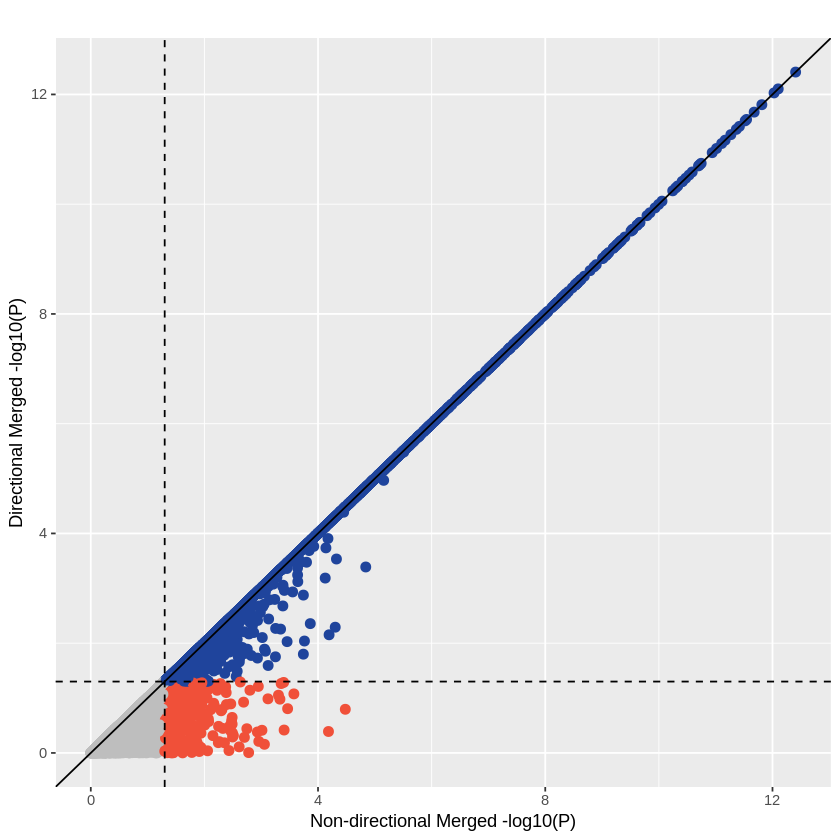

In [ ]:
# P-value를 -log10 변환하여 비교
lineplot_df <- data.frame(
    original = -log10(nondirectional_merged_pvals),
    modified = -log10(directional_merged_pvals)
)

# P-value 병합 결과 시각화 (Non-Directional vs. Directional)
ggplot(lineplot_df) +
    geom_point(size = 2.4, shape = 19,
        aes(original, modified,
            color = ifelse(original <= -log10(0.05),"gray",
                    ifelse(modified > -log10(0.05),"#1F449C","#F05039")))) +
    labs(title = "",
         x ="Non-directional Merged -log10(P)",
         y = "Directional Merged -log10(P)") +
    geom_hline(yintercept = 1.301, linetype = "dashed",
        col = 'black', size = 0.5) +
    geom_vline(xintercept = 1.301, linetype = "dashed",
        col = "black", size = 0.5) +
    geom_abline(size = 0.5, slope = 1,intercept = 0) +
    scale_color_identity()

- 대각선(y = x)에 가까운 점들: Brown과 DPM 방법의 결과가 유사함을 의미
- 대각선 위쪽(Modified P-value가 더 낮음): Directionality를 고려했을 때 더 유의미한 pathway로 평가됨
- 대각선 아래쪽(Modified P-value가 더 높음): 방향성을 반영했을 때 유의성이 감소한 pathway

## Directional P-value Merging 기반 Pathway 분석 수행

In [ ]:
# Directional Pathway Analysis 실행 (DPM 사용)
enriched_pathways_dir <- ActivePathways(
    scores = pval_matrix,              # P-value 행렬
    scores_direction = dir_matrix,      # Directionality 행렬 (+1/-1)
    constraints_vector = constraints_vector, # 방향성 가정값 (예: c(1,1) 또는 c(1,-1))
    gmt = geneset,                     # Gene Set 정보 (Reactome)
    merge_method = "DPM",               # P-value 병합 방법 (DPM 사용)
    significant = 1,                    # 유의성 기준 (1 이하 값 모두 포함)
    background = rownames(pval_matrix)  # 분석에 사용할 유전자 목록
)

242 terms were removed from gmt because they did not make the geneset_filter



## Directional vs. Non-Directional Pathway 분석 결과 비교

In [ ]:
# 상위 Pathway 결과 확인 (term_name 제외)
head(enriched_pathways_dir %>% select(-term_name))

term_id,adjusted_p_val,term_size,overlap,evidence,Genes_rna,Genes_protein
<chr>,<dbl>,<int>,<list>,<list>,<list>,<list>
REACTOME_2_LTR_CIRCLE_FORMATION,1,7,XRCC4,"rna , protein",XRCC4,NULL
REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,1,78,ABCB1,"rna , protein","ABCC3 , ABCB1 , ABCC10, ABCA7 , ABCD3 , PSMD12, PSMD14, ABCB8 , ABCB10, PSMB10, PSMD2 , PSMB6 , CFTR , PSMB7 , PSMC1 , PSMC5 , PSMA1 , PSMC3 , PSMB3 , PSMB5 , PSMD10, ABCA6 , ABCC1 , PSMA4 , DERL1 , PEX19 , PSMB2 , DERL2 , APOA1 , PSMA2 , EIF2S1, EIF2S2, PSMD4",ABCB1
REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS,1,8,"ABCD3, ABCA7","rna , protein","ABCA7, ABCD3, ABCA6, PEX19, APOA1",ABCD3
REACTOME_ABC_TRANSPORTER_DISORDERS,1,62,"ABCD4 , PSMD14, ABCA1 , PSMD12, PSMD2 , PSMB7 , PSMD3 , PSMC5 , PSMC3 , PSMC1 , PSMB5 , PSMB10, CFTR","rna , protein","ABCD4 , ABCA1 , PSMD12, PSMD14, PSMB10, PSMD2 , PSMB6 , CFTR , PSMB7 , PSMC1 , PSMC5 , PSMA1 , PSMC3 , PSMB3 , PSMB5 , PSMD10, PSMA4 , DERL1 , PSMB2 , DERL2 , APOA1 , PSMA2","PSMD3 , PSMD4 , PSMD14, PSMD2 , PSMC2 , OS9 , PSMD1 , PSMD11, PSMB7 , ABCA1 , PSMC3 , PSMB5 , PSMC5 , PSME1 , PSMD12"
REACTOME_ABERRANT_REGULATION_OF_MITOTIC_EXIT_IN_CANCER_DUE_TO_RB1_DEFECTS,1,14,"CDC27 , ANAPC2","rna , protein","ANAPC2, ANAPC4, CDC27 , ANAPC1, UBE2C , CDC23 , CDC16 , ANAPC5",CDC27
REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS,1,5,CDK6,"rna , protein","CDK4, CDK6",NULL


### Pathway 분석 결과 비교 (Non-Directional vs Directional)

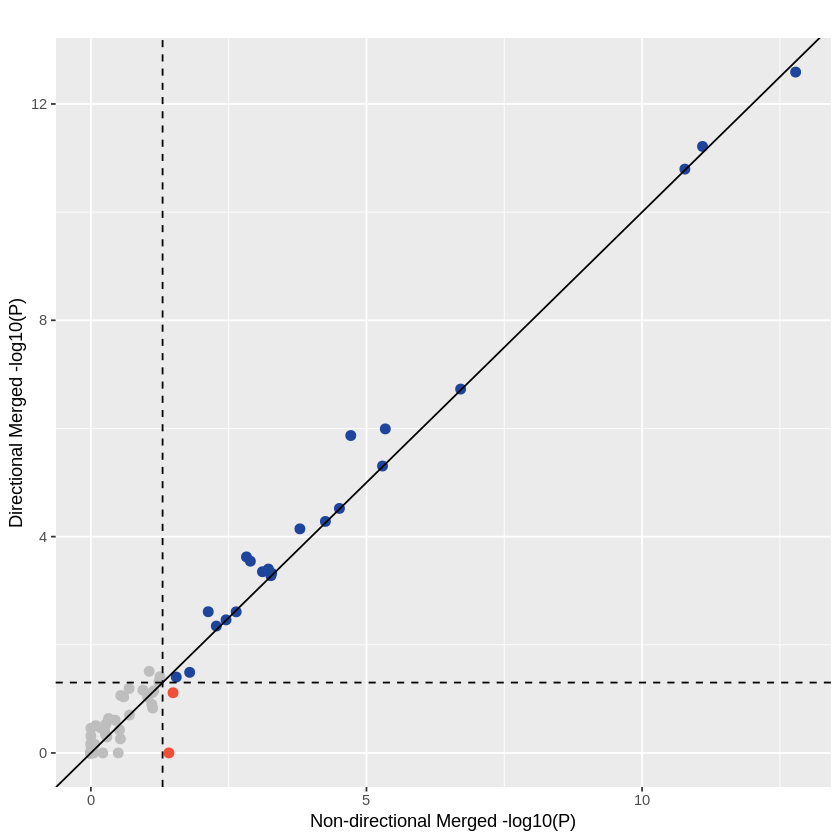

In [ ]:
# P-value를 -log10 변환하여 비교
lineplot_df <- data.frame(
    original = -log10(enriched_pathways_nondir$adjusted_p_val),
    modified = -log10(enriched_pathways_dir$adjusted_p_val)
)

# P-value 병합 결과 시각화 (Non-Directional vs. Directional)
ggplot(lineplot_df) +
    geom_point(size = 2.4, shape = 19,
        aes(original, modified,
            color = ifelse(original <= -log10(0.05),"gray",
                    ifelse(modified > -log10(0.05),"#1F449C","#F05039")))) +
    labs(title = "",
         x ="Non-directional Merged -log10(P)",
         y = "Directional Merged -log10(P)") +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed",
        col = 'black', size = 0.5) +
    geom_vline(xintercept = -log10(0.05), linetype = "dashed",
        col = "black", size = 0.5) +
    geom_abline(size = 0.5, slope = 1,intercept = 0) +
    scale_color_identity()

## Non-Directional 및 Directional 분석 결과 테이블 생성

In [ ]:
# Non-Directional 및 Directional 병합 P-value 및 순위 비교 테이블 생성
df1 = data.frame(
    gene = names(nondirectional_merged_pvals),   # 유전자 이름
    pvalue = pval_matrix,                        # 원본 P-value 행렬
    direct = dir_matrix,                         # Directionality 행렬
    pvalue_nondir = nondirectional_merged_pvals, # Non-Directional 병합 P-value
    rank_nondir = rank(nondirectional_merged_pvals), # Non-Directional P-value 순위
    pvalue_dir = directional_merged_pvals,       # Directional 병합 P-value
    rank_dir = rank(directional_merged_pvals)    # Directional P-value 순위
)

# 상위 몇 개 행 확인
head(df1)

,gene,pvalue.rna,pvalue.protein,direct.rna,direct.protein,pvalue_nondir,rank_nondir,pvalue_dir,rank_dir
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,A1BG,0.938868440,0.81957849,-1,1,9.344056e-01,7800.0,9.727963e-01,7678.0
A1CF,A1CF,0.000000014,0.00000812,-1,-1,2.710082e-09,65.5,2.710082e-09,65.5
A2M,A2M,0.494333780,0.85116516,1,1,7.185051e-01,7159.0,7.185051e-01,6514.0
A2ML1,A2ML1,0.000620000,0.01554281,1,1,7.886883e-04,1054.0,7.886883e-04,1023.0
AAAS,AAAS,0.127398071,0.51291151,-1,1,2.527421e-01,5024.0,5.464027e-01,5764.0
AACS,AACS,0.000383000,0.17747420,-1,-1,2.943331e-03,1449.0,2.943331e-03,1373.0


### Non-Directional 분석에서만 유의미한 Pathway 확인
**유의미한 Pathway 목록 추출**

In [ ]:
# Non-Directional 분석에서 유의미한 패스웨이 목록 추출
a = enriched_pathways_nondir %>% filter(adjusted_p_val < 0.05) %>% pull(term_id)

# Directional 분석에서 유의미한 패스웨이 목록 추출
b = enriched_pathways_dir %>% filter(adjusted_p_val < 0.05) %>% pull(term_id)

# Non-Directional 분석에서만 검출된 Pathway 목록
pathway_only_nondir = setdiff(a, b)

# 결과 출력
print(pathway_only_nondir)

[1] "REACTOME_GLUCONEOGENESIS" "REACTOME_KINESINS"       


**특정 Pathway 내 유전자 비교 (예: REACTOME_KINESINS)**

In [ ]:
# Non-Directional 분석에서 해당 Pathway에 포함된 유전자 개수 확인
genes_nondir_ovp = unlist(enriched_pathways_nondir %>% filter(term_id == "REACTOME_KINESINS") %>% pull(overlap))
print(paste("# of genes in nondir:", length(genes_nondir_ovp)))

# Directional 분석에서 해당 Pathway에 포함된 유전자 개수 확인
genes_dir_ovp = unlist(enriched_pathways_dir %>% filter(term_id == "REACTOME_KINESINS") %>% pull(overlap))
print(paste("# of genes in dir:", length(genes_dir_ovp)))

[1] "# of genes in nondir: 23"
[1] "# of genes in dir: 19"


### Non-Directional 분석에서만 포함된 유전자 확인

In [ ]:
# Non-Directional 분석에서만 포함된 유전자 찾기
setdiff(genes_nondir_ovp, genes_dir_ovp)

# 해당 유전자들의 P-value 및 Directionality 비교
df1 %>% filter(gene %in% setdiff(genes_nondir_ovp, genes_dir_ovp))

[1] "TUBB8"  "TUBA1C" "TUBA8"  "KLC2"

,gene,pvalue.rna,pvalue.protein,direct.rna,direct.protein,pvalue_nondir,rank_nondir,pvalue_dir,rank_dir
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KLC2,KLC2,0.49305820,0.03558667,-1,1,0.11216330,3873,0.2683165,4484
TUBA1C,TUBA1C,0.01214660,0.40427041,1,-1,0.04973612,3045,0.1570441,3803
TUBA8,TUBA8,0.02185018,0.51501797,-1,1,0.08465637,3564,0.1943319,4055
TUBB8,TUBB8,0.17368826,0.00820857,-1,1,0.02222861,2410,0.2076100,4137
